In [1]:
import pandas as pd
import random
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import urlopen
import seaborn as sns
import scipy.optimize as sco

In [ ]:
url=urlopen("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
soup = BeautifulSoup(url.read(), 'lxml')
tbody = soup.tbody
tr = tbody.find_all('tr')

In [ ]:
data = []
for t in tr:
    data.append(t.text.split('\n'))

raw_df = pd.DataFrame(data)
raw_df.columns = raw_df.iloc[0,:]
raw_df = raw_df.iloc[1:,:]
listed_companies=raw_df['Symbol'].tolist()

bourse=yf.download(listed_companies, start='2020-03-20',end='2023-02-15',interval="1d")
data=bourse['Close']

In [ ]:
esg_data=pd.DataFrame()

for ticker in listed_companies:
    ticker_name = yf.Ticker(ticker)
    try:
        if ticker_name.sustainability is not None: #if no response from Yahoo received, it will pass to next ticker
            ticker_df = ticker_name.sustainability.T #response dataframe
            ticker_df['symbol'] = ticker #adding new column 'symbol' in response df
            esg_data=pd.concat([esg_data,ticker_df],ignore_index=True)
    except (IndexError, ValueError) as e: #in case yfinance API misbehaves
        print(f'{ticker} did not run') #FYI
        pass

In [ ]:
new_esg_data=esg_data[['symbol','peerGroup','totalEsg']]
new_esg_data.columns=['Stock','Sector','ESG score']
new_esg_data.to_excel(r'C:\Users\niroo\Desktop\Jupyter\Projets\ESG.xlsx', index=False)

In [ ]:
data=bourse['Close']
data=data.reset_index()
data['Date'] = data['Date'].dt.tz_localize(None)
data=data.set_index('Date')
data.to_excel(r'C:\Users\niroo\Desktop\Jupyter\Projets\S&P500.xlsx')

In [2]:
esg=pd.read_excel(r'C:\Users\niroo\Desktop\Jupyter\Projets\Ethique\ESG.xlsx')
dataset=pd.read_excel(r'C:\Users\niroo\Desktop\Jupyter\Projets\Ethique\S&P500.xlsx')

In [3]:
class ESG_filter:
    
    def __init__(self,esg_data):
        self.esg_data=esg_data
        
    def plot_sectors(self):
        stats=self.esg_data.groupby(by='Sector').mean().reset_index()
        average=self.esg_data['ESG score'].mean(numeric_only=None)
        colors=['darkcyan' if (stat< average) else 'mediumspringgreen' for stat in self.esg_data['ESG score']]
        plt.figure(figsize=(15,20))
        ax=sns.barplot(x=self.esg_data['ESG score'], y=self.esg_data['Sector'], data=stats, palette=colors, ci=None)
        
    def order_data(self):
        ordered_data=self.esg_data.sort_values(by='ESG score')
        best_companies=ordered_data[:len(ordered_data)//2]
        worst_companies=ordered_data[len(ordered_data)//2:]
        
        return best_companies,worst_companies
    
    def sectors(self):
        stock_sectors=dict()
        sectors=self.esg_data['Sector'].unique()
        for sector in sectors:
            stock_sectors[sector]=esg.loc[self.esg_data['Sector']==sector]
        return stock_sectors
    

In [4]:
class Randomize:
    def __init__(self,assets,num_assets):
        self.assets=assets
        self.num_assets=num_assets
        
    def random_assets(self):
        unique_assets=self.assets['Stock'].unique()
        random_assets=np.random.choice(unique_assets,self.num_assets,replace=False)
        return random_assets

In [5]:
class Dataset:
    def __init__(self,data,stocks):
        self.data=data
        self.stocks=stocks
        
    def database(self):
        #todrop=self.data.columns[self.data.isnull().any()]
        #data=self.data.drop(todrop,axis=1).set_index('Date')
        data=self.data.dropna(axis='columns')
        return data[self.stocks]
    
    def returns(self):
        return self.database().pct_change()


In [6]:
class Portfolio:
    
    def __init__(self,data):
        self.data=data
        self.max_iterations=1000
    
    def random_weight(self):
        weight=np.random.random(len(self.data.columns))
        weight /= weight.sum()
        return weight
    
    def variance(self,weight):
        variance=np.dot(weight.T,np.dot(self.data.cov()*252,weight))
        return variance
    
    def performance(self,weight):
        perfan=np.sum(self.data.mean()*weight)*252
        return perfan
    
    def Sharpe_ratio(self,weight):
        R=self.performance(weight)
        V=self.variance(weight)
        SR=R/V
        return -1*SR
    
    def fit(self):
        
        portfolio_variance=[]
        portfolio_returns=[]
        sharpe_ratio=[]
        weights=[]
        
        for i in range(self.max_iterations):
            weight=self.random_weight()
            var=self.variance(weight)
            returns=self.performance(weight)
            SR= returns/var
            portfolio_variance.append(var)
            portfolio_returns.append(returns)
            sharpe_ratio.append(SR)
            weights.append(weight)
               
        return portfolio_returns,portfolio_variance,sharpe_ratio,weights
    
    
    def sum_equal_one(self, weight):
        return np.sum(weight) - 1   
    
    def optimize(self):
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        constraints = [{'type': 'eq', 'fun': self.sum_equal_one}]
        optimum_weights = sco.minimize(self.variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        #optimum_SR = sco.minimize(self.Sharpe_ratio, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        return optimum_weights.x
    
    
    def VaR(self):
        
        optimum_weight=self.optimize()
        portfolio_return=(optimum_weight*self.data).sum(axis=1)
        
        return np.percentile(portfolio_return,5,interpolation='lower')
    
    def plot_VaR(self):
        
        optimum_weight=self.optimize()
        portfolio_return=(optimum_weight*self.data).sum(axis=1)
        VaR=self.VaR()
        hist, bins, _ = plt.hist(portfolio_return, bins=50, density=True,color='lightskyblue',edgecolor='white')
        mask = (bins[:-1] < VaR)
        for i in range(len(mask)):
            if mask[i]:
                plt.bar(bins[i], hist[i], width=bins[i+1]-bins[i],alpha=0.5, color='red',edgecolor='white')
        plt.text(VaR-0.015, max(hist)*0.9, 'VaR at '+str(round(VaR,3))+'%', ha='center', va='center', color='r', fontsize=10)
        plt.ylabel('Frequency')
        plt.title('Value At Risk 95%')
        plt.show()
        
        
    def plot_portfolio(self,cmap=None):
        
        if (cmap==None):
            self.cmap='viridis'
        else:
            self.cmap=cmap
            
        sample=self.fit()
        
        X=sample[1]
        Y=sample[0]
        c=sample[2]
        
        optimum_weights=self.optimize()
        #optimum_SR=self.optimize()[1]
        
        minimum_variance=self.variance(optimum_weights)
        optimum_returns=self.performance(optimum_weights)
        #maximum_sharpe_ratio_return=self.performance(optimum_SR)
        #max_sr_variance=self.variance(optimum_SR)
        
        plt.scatter(X,Y,c=c, cmap=self.cmap)
        #plt.scatter(max_sr_variance,maximum_sharpe_ratio_return,c='red',marker='x')
        plt.plot(minimum_variance,optimum_returns,c='red',marker='.',markersize=15)
        plt.title('Frontiere efficiente')
        plt.xlabel('Variance du portefeuille')
        plt.ylabel('Esperance du portefeuille')
        plt.show()
        
    

In [7]:
esg_data=ESG_filter(esg)
best=esg_data.order_data()[0]
worst=esg_data.order_data()[1]

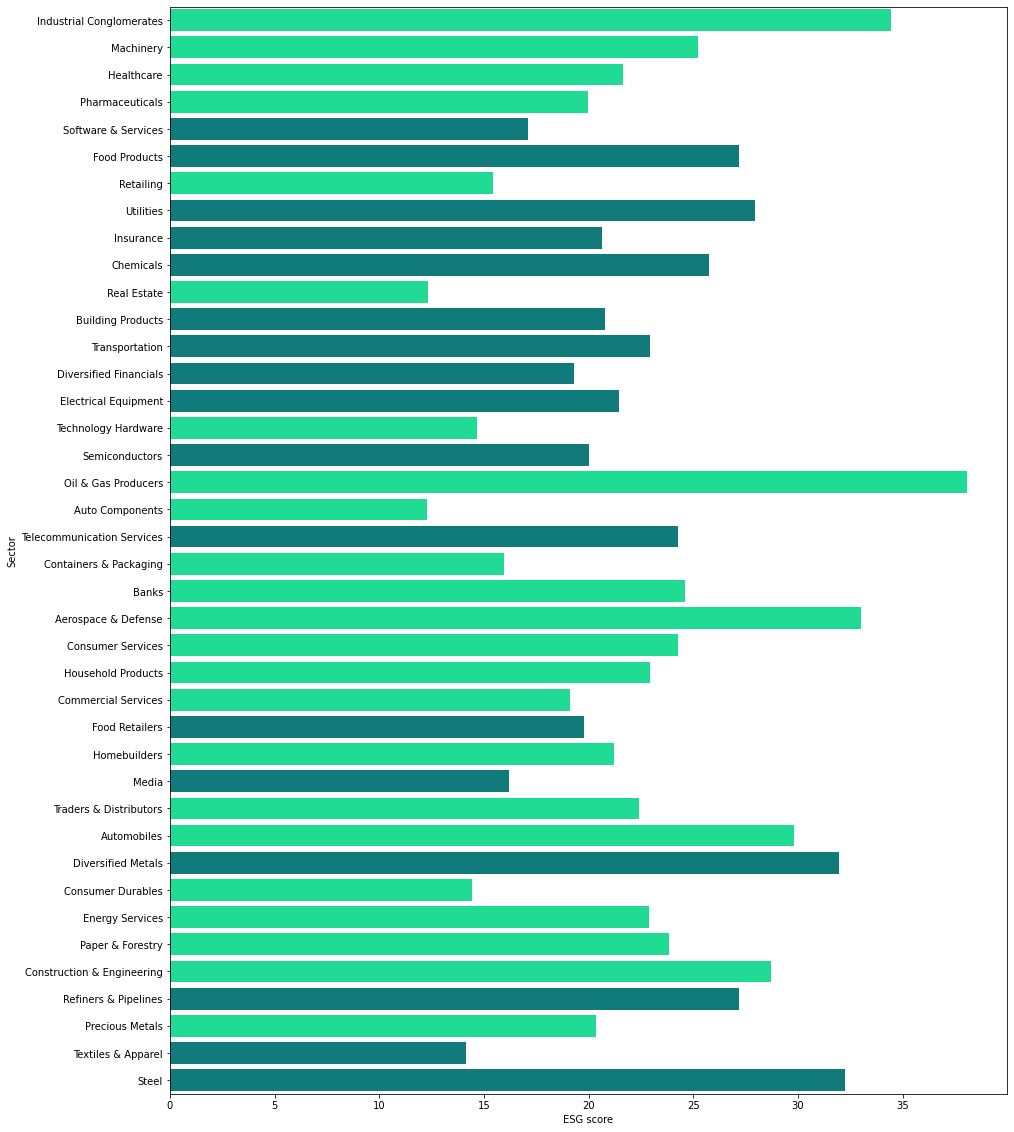

In [8]:
esg_data.plot_sectors()

In [9]:
best50=best[:50]
worst50=worst[50:]

In [ ]:
best_random=Randomize(best,2).random_assets()
test2=Dataset(dataset,best_random).returns()
portfolio=Portfolio(test2).fit()
wopt=Portfolio(test2).optimize()
wopt[0]

In [ ]:
print(Portfolio(test2).VaR())
Portfolio(test2).plot_VaR()

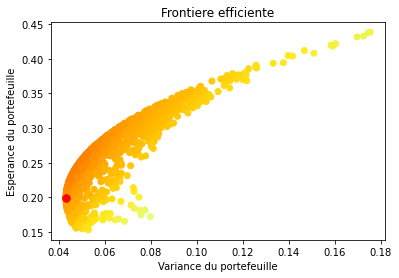

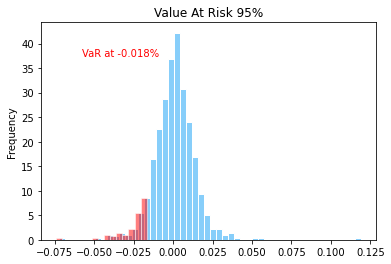

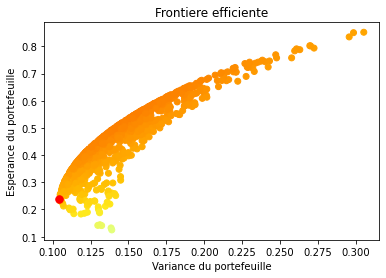

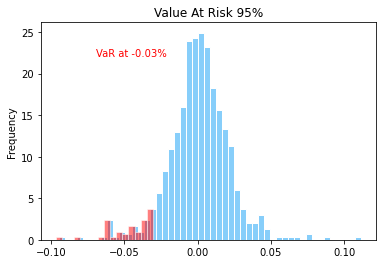

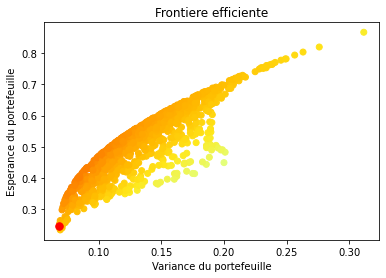

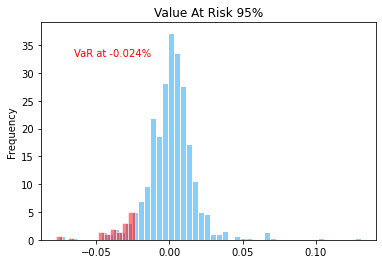

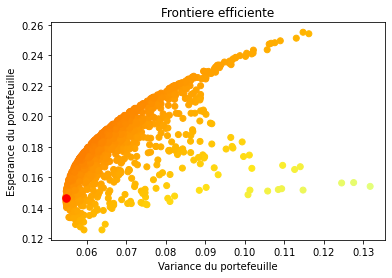

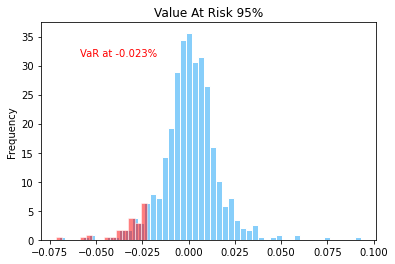

In [12]:
for i in range(4):
    worst_random=Randomize(worst,3).random_assets()
    test=Dataset(dataset,worst_random).returns()
    portfolio=Portfolio(test)
    portfolio.plot_portfolio('Wistia')
    
    portfolio.plot_VaR()

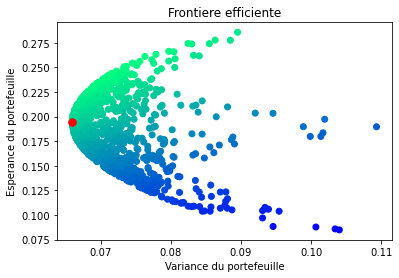

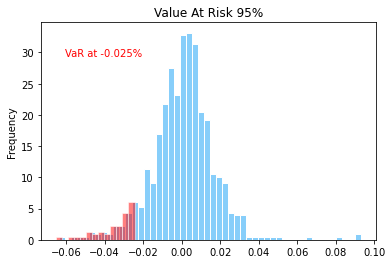

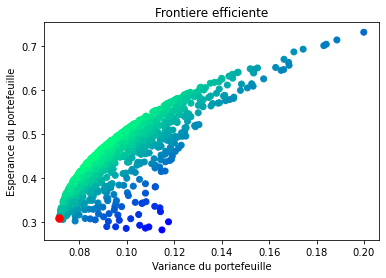

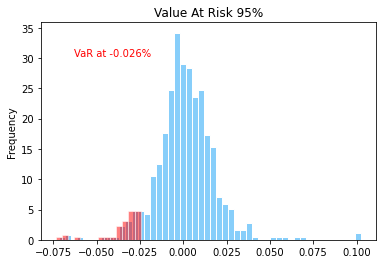

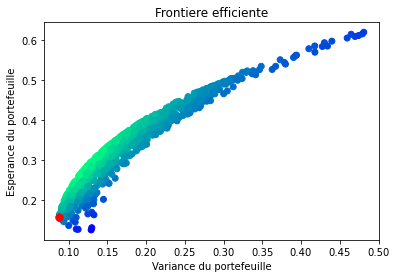

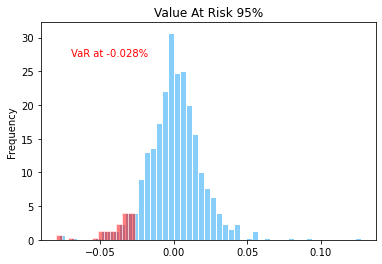

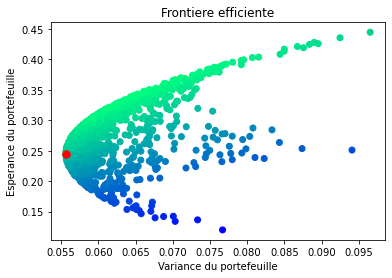

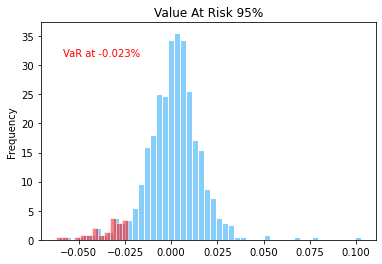

In [13]:
for i in range(4):
    best_random=Randomize(best,3).random_assets()
    test2=Dataset(dataset,best_random).returns()
    portfolio=Portfolio(test2)
    portfolio.plot_portfolio('winter')
    portfolio.plot_VaR()

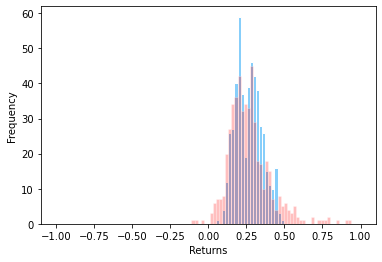

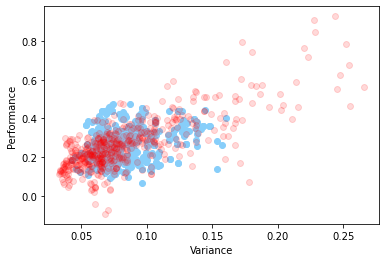

In [35]:
high_score_performance=[]
low_score_performance=[]
high_score_variance=[]
low_score_variance=[]
n=2

for i in range(500):
    best_random=Randomize(best50,n).random_assets()
    worst_random=Randomize(worst50,n).random_assets()
    best_dataset=Dataset(dataset,best_random).returns()
    worst_dataset=Dataset(dataset,worst_random).returns()

    best_portfolio=Portfolio(best_dataset)
    worst_portfolio=Portfolio(worst_dataset)
    performance_high=best_portfolio.performance(best_portfolio.optimize())
    performance_low=worst_portfolio.performance(worst_portfolio.optimize())
    variance_high=best_portfolio.variance(best_portfolio.optimize())
    variance_low=worst_portfolio.variance(worst_portfolio.optimize())
    
    high_score_performance.append(performance_high)
    low_score_performance.append(performance_low)
    high_score_variance.append(variance_high)
    low_score_variance.append(variance_low)

bins=np.linspace(-1, 1, 100)
plt.hist(high_score_performance,bins,alpha=1,color='lightskyblue',edgecolor='white')
plt.hist(low_score_performance,bins,alpha=0.25,color='red',edgecolor='white')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

plt.scatter(high_score_variance,high_score_performance,color='lightskyblue')
plt.scatter(low_score_variance,low_score_performance,alpha=0.15,color='red')
plt.ylabel('Performance')
plt.xlabel('Variance')
plt.show()

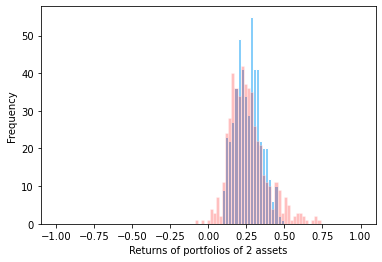

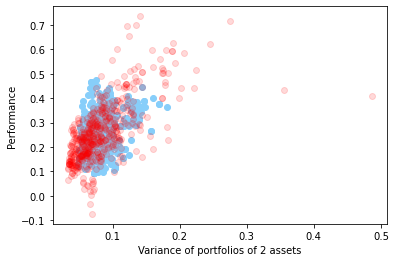

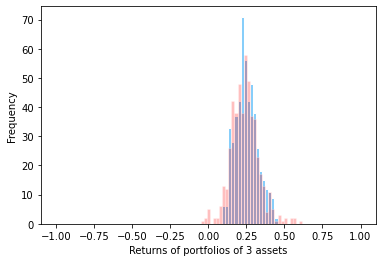

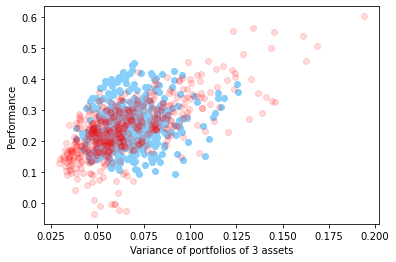

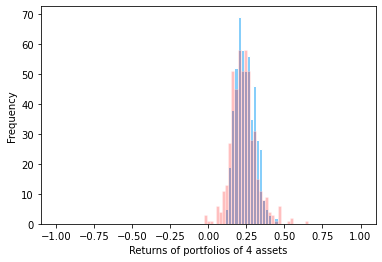

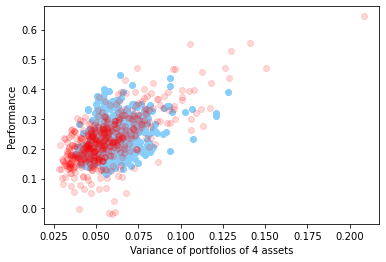

In [46]:
max_assets = 5

for n in range(2,max_assets):

    high_score_performance=[]
    low_score_performance=[]
    high_score_variance=[]
    low_score_variance=[]

    for i in range(500):
        best_random=Randomize(best50,n).random_assets()
        worst_random=Randomize(worst50,n).random_assets()
        best_dataset=Dataset(dataset,best_random).returns()
        worst_dataset=Dataset(dataset,worst_random).returns()

        best_portfolio=Portfolio(best_dataset)
        worst_portfolio=Portfolio(worst_dataset)
        performance_high=best_portfolio.performance(best_portfolio.optimize())
        performance_low=worst_portfolio.performance(worst_portfolio.optimize())
        variance_high=best_portfolio.variance(best_portfolio.optimize())
        variance_low=worst_portfolio.variance(worst_portfolio.optimize())

        high_score_performance.append(performance_high)
        low_score_performance.append(performance_low)
        high_score_variance.append(variance_high)
        low_score_variance.append(variance_low)

    bins=np.linspace(-1, 1, 100)
    plt.hist(high_score_performance,bins,alpha=1,color='lightskyblue',edgecolor='white')
    plt.hist(low_score_performance,bins,alpha=0.25,color='red',edgecolor='white')
    plt.xlabel('Returns of portfolios of '+str(n)+' assets')
    plt.ylabel('Frequency')
    plt.show()

    plt.scatter(high_score_variance,high_score_performance,color='lightskyblue')
    plt.scatter(low_score_variance,low_score_performance,alpha=0.15,color='red')
    plt.ylabel('Performance')
    plt.xlabel('Variance of portfolios of '+str(n)+' assets')
    plt.show()